In [33]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U pretrainedmodels efficientnet-pytorch albumentations

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-1_5y20wp
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-1_5y20wp
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks

All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [34]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [37]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [38]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [39]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import numpy as np

In [61]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
lambda = 1 - (x2-x1)*(y2-y1)/(W*H)
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.unlabelled_class = self.CLASSES.index('unlabelled')

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    # Refer to official cutmix impl. https://github.com/clovaai/CutMix-PyTorch/blob/2d8eb68faff7fe4962776ad51d175c3b01a25734/train.py#L279
    def rand_bbox(self, size, lam):
        H, W = size[0], size[1]
        cut_rat = np.sqrt(1.0 - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W - 1)
        bby1 = np.clip(cy - cut_h // 2, 0, H - 1)
        bbx2 = np.clip(cx + cut_w // 2, 0, W - 1)
        bby2 = np.clip(cy + cut_h // 2, 0, H - 1)
        return bbx1, bby1, bbx2, bby2

    # mask for the cut loss
    def lcut_mask(self, H, W, start_x, start_y, end_x, end_y, include_inside):
        a = self.lcut_alpha
        b = self.lcut_beta
        img = torch.zeros((H, W))
        # whether to include loss inside of the cut out rectangle
        max_offset = b + 1 if include_inside else 0
        for offset in range(-b, max_offset):
            loss = a ** abs(offset)
            x1 = np.clip(start_x + offset, 0, W - 1)
            x2 = np.clip(end_x - offset, 0, W - 1)
            y1 = np.clip(start_y + offset, 0, H - 1)
            y2 = np.clip(end_y - offset, 0, H - 1)
            img[y1: y2 + 1, x1] = loss
            img[y1: y2 + 1, x2] = loss
            img[y1, x1:x2 + 1] = loss
            img[y2, x1:x2 + 1] = loss
        return img

    def make_one_hot(self, labels, C):  # labels: [N]
        """turn a batch of labels to the one-hot form"""
        labels = labels.unsqueeze(1)  # [N, 1]
        one_hot = torch.zeros(labels.size(0), C).cuda()
        target = one_hot.scatter_(1, labels, 1)
        return target

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [77]:
class CutOutDataset(Dataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        lcut_alpha,
        lcut_beta,
        classes=None,
        augmentation=None,
        preprocessing=None,
  ):
        super().__init__(images_dir, masks_dir, classes, augmentation, preprocessing)
        self.lcut_alpha = lcut_alpha
        self.lcut_beta = lcut_beta

    # Refer to official cutmix impl.: https://github.com/clovaai/CutMix-PyTorch/blob/2d8eb68faff7fe4962776ad51d175c3b01a25734/train.py#L234
    def cutout(self, img, mask):
        shape = img.shape
        h, w, _ = shape
        self.lam = np.random.beta(1, 1)

        bbx1, bby1, bbx2, bby2 = self.rand_bbox(
            shape, self.lam
        )  # self.lam is the area ratio of the remaining part over the original image

        # get new image
        cutout_mask = np.ones((h, w, 1))
        cutout_mask[bby1:bby2 + 1, bbx1:bbx2 + 1] = 0
        input_cut = img * cutout_mask

        # adjust lambda to exactly match pixel ratio
        self.lam = 1 - (bbx2 - bbx1 + 1) * (bby2 - bby1 + 1) / (h * w)

        mask_mix = np.where(cutout_mask, mask, self.unlabelled_class)

        lcut_mask = self.lcut_mask(h, w, bbx1, bby1, bbx2, bby2, include_inside=False)

        return input_cut, mask_mix, lcut_mask

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply cutout
        image, mask, lcut_mask = self.cutout(image, mask)

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image.astype(np.uint8), mask, lcut_mask

In [78]:
class CutMixDataset(Dataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        lcut_alpha,
        lcut_beta,
        classes=None,
        augmentation=None,
        preprocessing=None,
  ):
        super().__init__(images_dir, masks_dir, classes, augmentation, preprocessing)
        self.lcut_alpha = lcut_alpha
        self.lcut_beta = lcut_beta
        self.ids_shuffled = self.ids.copy()
        random.shuffle(self.ids_shuffled)

        self.images_fps_shuffled = [os.path.join(images_dir, image_id) for image_id in self.ids_shuffled]
        self.masks_fps_shuffled = [os.path.join(masks_dir, image_id) for image_id in self.ids_shuffled]

    # Refer to official cutmix impl.: https://github.com/clovaai/CutMix-PyTorch/blob/2d8eb68faff7fe4962776ad51d175c3b01a25734/train.py#L234
    def cutmix(self, img1, mask1, img2, mask2):
        shape = img1.shape
        h, w, _ = shape
        self.lam = np.random.beta(1, 1)

        bbx1, bby1, bbx2, bby2 = self.rand_bbox(
            shape, self.lam
        )  # self.lam is the area ratio of the remaining part over the original image

        # get new image
        cutmix_mask = np.ones((h, w, 1))
        cutmix_mask[bby1:bby2 + 1, bbx1:bbx2 + 1] = 0
        input_cut = img1 * cutmix_mask + img2 * (1 - cutmix_mask)

        # adjust lambda to exactly match pixel ratio
        self.lam = 1 - (bbx2 - bbx1 + 1) * (bby2 - bby1 + 1) / (h * w)

        # linearly interpolate the mask
        mask_mix = cutmix_mask * mask1 + (1 - cutmix_mask) * mask2

        lcut_mask = self.lcut_mask(h, w, bbx1, bby1, bbx2, bby2, include_inside=True)

        return input_cut, mask_mix, lcut_mask

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        image2 = cv2.imread(self.images_fps_shuffled[i])
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        mask2 = cv2.imread(self.masks_fps_shuffled[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        masks2 = [(mask2 == v) for v in self.class_values]
        mask2 = np.stack(masks2, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

            sample2 = self.augmentation(image=image2, mask=mask2)
            image2, mask2 = sample2['image'], sample2['mask']

        # apply cutout
        image, mask, lcut_mask = self.cutmix(image, mask, image2, mask2)

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image.astype(np.uint8), mask, lcut_mask

(360, 480, 3)
272:359, 347:479


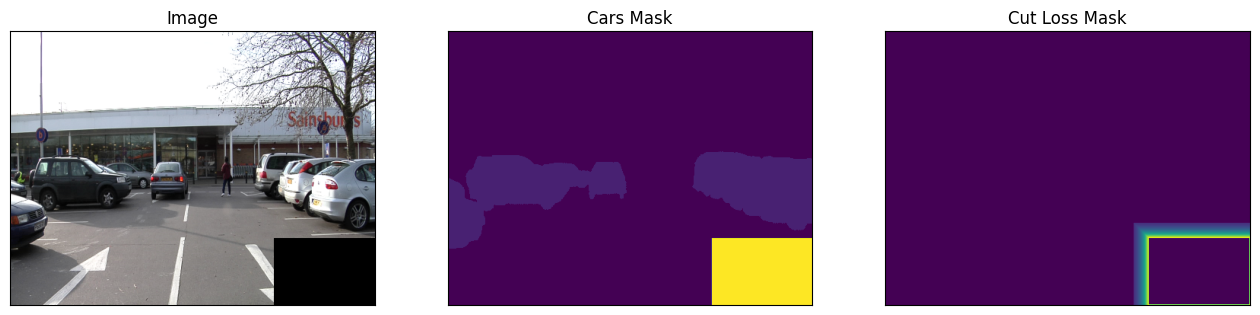

In [88]:
dataset = CutOutDataset(x_train_dir, y_train_dir, lcut_alpha=0.9, lcut_beta = 20, classes=['car'])

image, mask, lcut_mask = dataset[40] # get some sample
visualize(
    image=image,
    cars_mask=mask.squeeze(),
    cut_loss_mask=lcut_mask
)

(360, 480, 3)
0:228, 112:434


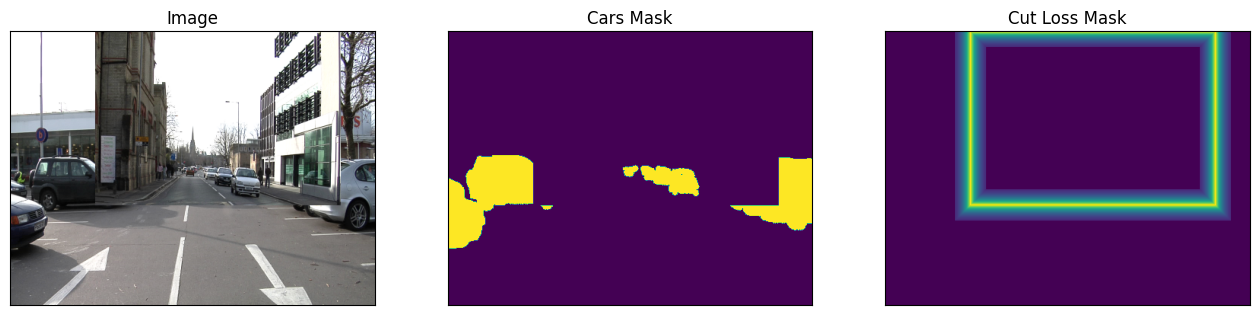

In [89]:
dataset = CutMixDataset(x_train_dir, y_train_dir, lcut_alpha=0.9, lcut_beta = 20, classes=['car'])

image, mask, lcut_mask = dataset[40] # get some sample
visualize(
    image=image,
    cars_mask=mask.squeeze(),
    cut_loss_mask=lcut_mask
)

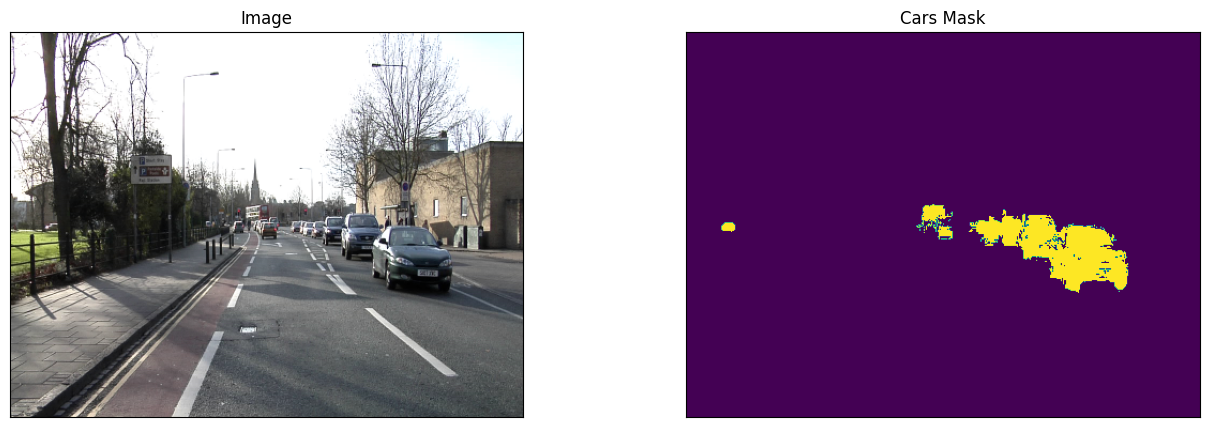

In [90]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4] # get some sample
visualize(
    image=image,
    cars_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

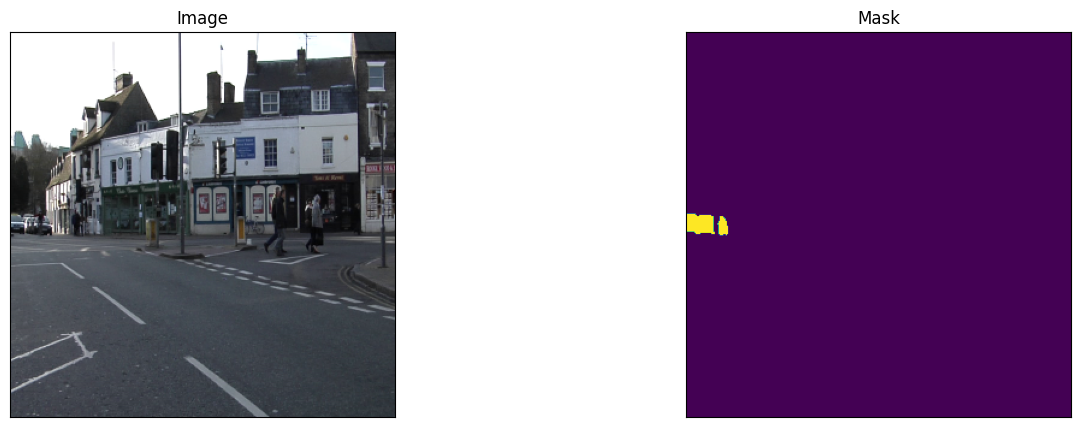

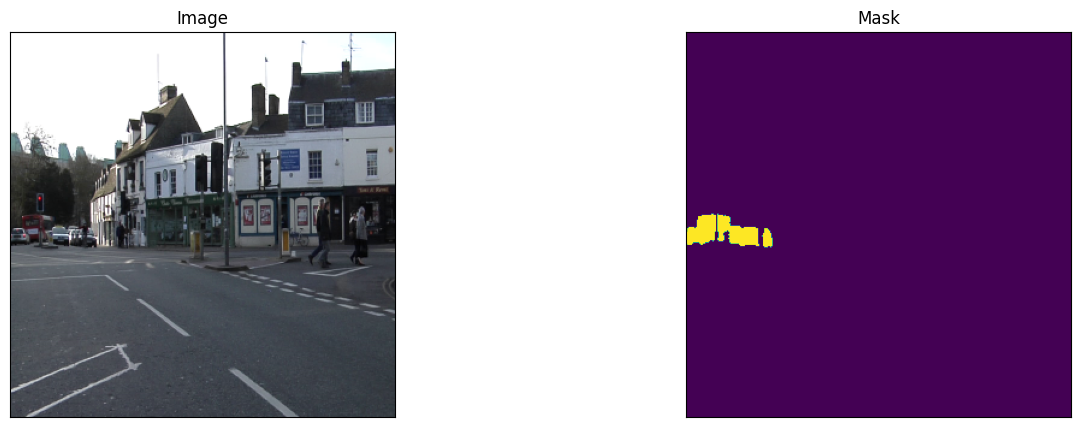

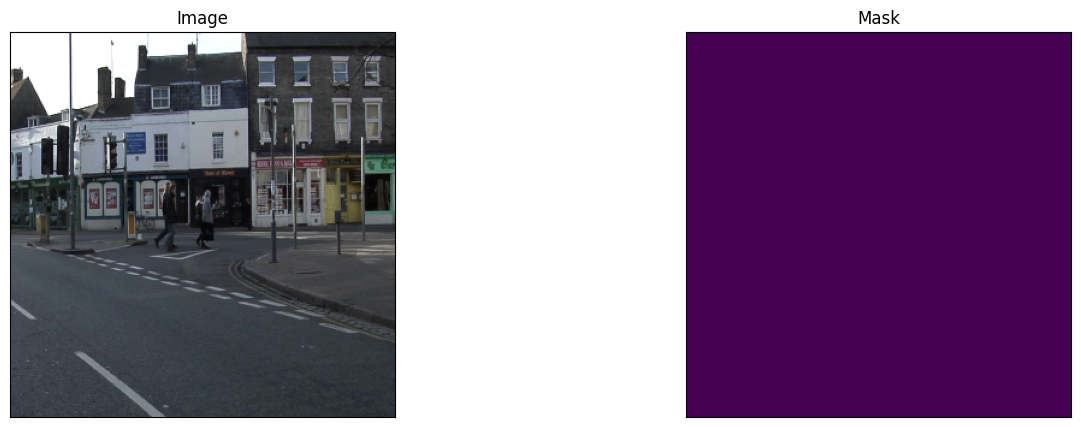

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [ ]:
import torch
import numpy as np
# np.object = object
import segmentation_models_pytorch as smp

In [ ]:
# ENCODER = 'se_resnext50_32x4d'
# ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
# ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
# DEVICE = 'cuda'

# # create segmentation model with pretrained encoder
# model = smp.FPN(
#     encoder_name=ENCODER,
#     encoder_weights=ENCODER_WEIGHTS,
#     classes=len(CLASSES),
#     activation=ACTIVATION,
# )

model = smp.Unet('resnet34', encoder_weights='imagenet', activation='sigmoid')

preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet18', pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 72.7MB/s]


In [ ]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.losses.DiceLoss(mode = 'binary')
loss.__name__ = 'dice_loss'
from segmentation_models_pytorch import utils
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    # device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    # device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

# epochs = [int(i + 1) for i in range(40)]
# plt.clf()
# plt.plot(epochs, train_losses, label='Train Loss', color = 'r')
# plt.plot(epochs, test_losses, label='Test Loss', color = 'g')

# plt.title('Losses for ' + name)
# plt.xlabel('Epoch Number')
# plt.ylabel('Loss')

# plt.legend()

# plt.savefig(name + 'Loss.jpg')
# plt.clf()

# plt.plot(epochs, train_accs, label='Train IOU', color = 'r')
# plt.plot(epochs, test_accs, label='Test IOU', color = 'g')

# plt.title('Accuracy for ' + name)
# plt.xlabel('Epoch Number')
# plt.ylabel('Accuracy')

# plt.legend()

# plt.savefig(name + 'Accuracy.jpg')

max_score = 0
train_losses = []
test_losses = []
train_ious = []
test_ious = []

for i in range(0, 40):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_wa.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    train_losses.append(train_logs['dice_loss'])
    test_losses.append(valid_logs['dice_loss'])
    train_ious.append(train_logs['iou_score'])
    test_ious.append(valid_logs['iou_score'])
print(max_score)


Epoch: 0
train:  54%|█████▍    | 25/46 [08:19<06:59, 19.99s/it, dice_loss - 0.8755, iou_score - 0.1312]


KeyboardInterrupt: ignored

In [ ]:
epochs = [int(i + 1) for i in range(25)]
plt.clf()
plt.plot(epochs, train_losses[:25], label='Train Loss', color = 'r')
plt.plot(epochs, test_losses[:25], label='Test Loss', color = 'g')

plt.title('Losses for Baseline Unet Segmentation Model Without Data Augmentation')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.legend()

plt.savefig('Baseline_Loss_wa.jpg')
plt.clf()

plt.plot(epochs, train_ious[:25], label='Train IoU', color = 'r')
plt.plot(epochs, test_ious[:25], label='Test IoU', color = 'g')

plt.title('IoU for for Baseline Unet Segmentation Model Without Data Augmentation')
plt.xlabel('Epoch Number')
plt.ylabel('IoU')

plt.legend()

plt.savefig('Baseline_IoU_wa.jpg')

In [ ]:
!cp /content/best_model_wa.pth /content/drive/MyDrive
!cp /content/Baseline_Loss_wa.jpg /content/drive/MyDrive
!cp /content/Baseline_IoU_wa.jpg /content/drive/MyDrive

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model_wa.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
)

logs = test_epoch.run(test_dataloader)

## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir,
    classes=CLASSES,
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )